In [8]:
from vowpalwabbit import pyvw
import matplotlib.pyplot as plt
import pandas as pd
import random
import math
import numpy as np

NUM_ITERATIONS = 2500
shared_contexts = ["corporate", "trade"]
torso_items = ["tshirt", "buttonupshirt", "highvis"]
legs_items = ["workpants", "formalpants", "shorts"]
feet_items = ["formalshoes", "runners", "flipflops", "boots"]

# Scenario: Outfit optimization
- Slots are different clothing types
- Actions are the individual pieces of clothing for each slot

![slates_scenario.png](./slates_scenario.png)

# Reward function
The chosen action and context is supplied to the this to determine the reward. Noise is injected to make the learning problem harder and reflect how in reality there may be variation in how the reward function reacts, possibly because of missing information.

In [9]:
def noise(center, stddev=0.075):
    return np.random.normal(loc = center, scale=0.075)

def reward_function(shared_context, torso_index, legs_index, feet_index):
    if shared_context == "corporate":
        torso_values = [noise(0.3), noise(0.5), noise(0.1)]
        legs_val = [noise(0.1), noise(0.5), noise(0.3)]    
        feet_values = [noise(0.4), noise(0.3), noise(0.05), noise(0.1)]
    if shared_context == "trade":
        torso_values = [noise(0.15), noise(0.2), noise(0.4)]
        legs_val = [noise(0.5), noise(0.2), noise(0.35)]    
        feet_values = [noise(0.2), noise(0.2), noise(0.1), noise(0.5)]
    
    return torso_values[torso_index] + legs_val[legs_index] + feet_values[feet_index]
    

# Slates

In [10]:
def generate_slates_text_format(shared_context):
    return [
       f"slates shared |User {shared_context}",
        "slates action 0 |Action tshirt", 
        "slates action 0 |Action buttonupshirt", 
        "slates action 0 |Action highvis", 
        "slates action 1 |Action workpants", 
        "slates action 1 |Action formalpants", 
        "slates action 1 |Action shorts", 
        "slates action 2 |Action formalshoes", 
        "slates action 2 |Action runners", 
        "slates action 2 |Action flipflops", 
        "slates action 2 |Action boots", 
        "slates slot |Slot torso", 
        "slates slot |Slot legs",
        "slates slot |Slot feet"
    ]

def generate_slates_text_format_with_label(shared_context, reward, chosen_torso_index, chosen_torso_prob, chosen_legs_index, chosen_legs_prob, chosen_feet_index, chosen_feet_prob):
    return [
       f"slates shared {-1*reward} |User {shared_context}",
        "slates action 0 |Action tshirt", 
        "slates action 0 |Action buttonupshirt", 
        "slates action 0 |Action highvis", 
        "slates action 1 |Action workpants", 
        "slates action 1 |Action formalpants", 
        "slates action 1 |Action shorts", 
        "slates action 2 |Action formalshoes", 
        "slates action 2 |Action runners", 
        "slates action 2 |Action flipflops", 
        "slates action 2 |Action boots", 
        f"slates slot {chosen_torso_index}:{chosen_torso_prob} |Slot torso", 
        f"slates slot {chosen_legs_index}:{chosen_legs_prob} |Slot legs",
        f"slates slot {chosen_feet_index}:{chosen_feet_prob} |Slot feet"

    ]

In [11]:
slates_vw = pyvw.vw("--slates --epsilon 0.2 --interactions SA UAS US UA -l 0.05 --power_t 0")

slates_rewards = []
for _ in range(NUM_ITERATIONS):
    shared_context = random.choice(shared_contexts)
    slates_prediction = slates_vw.predict(generate_slates_text_format(shared_context))
    torso_index, torso_prob = slates_prediction[0][0]
    legs_index, legs_prob = slates_prediction[1][0]    
    feet_index, feet_prob = slates_prediction[2][0]
    reward = reward_function(shared_context, torso_index, legs_index, feet_index)
    slates_rewards.append(reward)
    slates_vw.learn(generate_slates_text_format_with_label(shared_context,reward, torso_index, torso_prob, legs_index, legs_prob, feet_index, feet_prob))

slates_vw.finish()

# Contextual Bandit
This involves expanding out *all* possible combinations.

In [12]:
def generate_combinations(shared_context, torso_items, legs_items, feet_items):
    examples = [f"shared |User {shared_context}"]
    descriptions = []
    for i, torso in enumerate(torso_items):
        for j, legs in enumerate(legs_items):
            for k, feet in enumerate(feet_items):
                examples.append(f"|Action torso={torso} legs={legs} feet={feet}")
                descriptions.append((i,j,k))
                
    return examples, descriptions

def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1 / total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if(sum_prob > draw):
            return index, prob


In [13]:
cb_vw = pyvw.vw("--cb_explore_adf --epsilon 0.2 --interactions AA AU AAU -l 0.05 --power_t 0")

cb_rewards = []
for _ in range(NUM_ITERATIONS):
    shared_context = random.choice(shared_contexts)
    examples, indices = generate_combinations(shared_context, torso_items, legs_items, feet_items)
    cb_prediction = cb_vw.predict(examples)
    chosen_index, prob = sample_custom_pmf(cb_prediction)
    torso_index, legs_index, feet_index = indices[chosen_index]
    reward = reward_function(shared_context, torso_index, legs_index, feet_index)
    cb_rewards.append(reward)
    examples[chosen_index + 1]= f"0:{-1*reward}:{prob} {examples[chosen_index + 1]}"
    cb_vw.learn(examples)

cb_vw.finish()

# Comparison

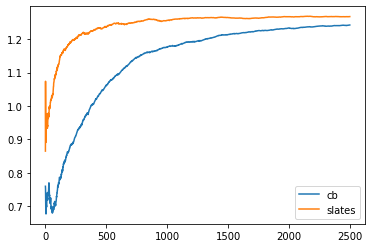

In [14]:
plt.plot(pd.Series(cb_rewards).expanding().mean())
plt.plot(pd.Series(slates_rewards).expanding().mean())
plt.legend(['cb', 'slates'])
